# [E-10]Translator

In [1]:

import tensorflow
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

In [2]:
"""  $ mkdir -p ~/aiffel/translator_seq2seq/data   
$ mkdir -p ~/aiffel/translator_seq2seq/models   
$ wget https://www.manythings.org/anki/fra-eng.zip      
$ mv fra-eng.zip  ~/aiffel/translator_seq2seq/data   
$ cd ~/aiffel/translator_seq2seq/data && unzip fra-eng.zip   """

'  $ mkdir -p ~/aiffel/translator_seq2seq/data   \n$ mkdir -p ~/aiffel/translator_seq2seq/models   \n$ wget https://www.manythings.org/anki/fra-eng.zip      \n$ mv fra-eng.zip  ~/aiffel/translator_seq2seq/data   \n$ cd ~/aiffel/translator_seq2seq/data && unzip fra-eng.zip   '

In [3]:

file_path = './data/seq2seq/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
202025,Pregnant women often experience morning sickness.,Les femmes enceintes ont souvent des nausées l...,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
74556,Tom is fluent in French.,Tom parle le français couramment.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
155816,I don't like any of these pictures.,Je n'aime aucune de ces images.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
11595,I'm not bitter.,Je ne suis pas amère.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
187243,Nothing happens unless you make it happen.,Rien ne se passe à moins que vous ne fassiez e...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [4]:
lines = lines[['eng', 'fra']][:33000] # 33000만개 샘플 사용
lines.sample(5)

,eng,fra
20460,I suffered a lot.,J'ai beaucoup souffert.
22260,They fell silent.,Elles se sont tues.
9636,We're careful.,Nous sommes prudents.
13872,Are you envious?,Êtes-vous jaloux ?
9980,You're grumpy.,Tu es bougonne.


## Step 1. 정제, 정규화, 전처리(영어, 프랑스어 모두)

1. 구두점(Punctuation)을 단어와 분리해주세요.
2. 소문자로 바꿔주세요.
3. 띄어쓰기 단위로 토큰화를 수행하세요.

## 1-1 구두점(Punctuation)을 단어와 분리해주세요.

In [5]:
lines.eng = lines.eng.apply(lambda x:re.sub(r"([?.!,¿])", r" \1", x) )
lines.fra = lines.fra.apply(lambda x:re.sub(r"([?.!,¿])", r" \1", x) )

In [6]:
lines.eng.head(3)

0    Go .
1    Go .
2    Go .
Name: eng, dtype: object

## 1-2 소문자로 바꿔주세요.

In [7]:
lines.eng = lines.eng.apply(lambda x: x.lower()) 
lines.fra = lines.fra.apply(lambda x: x.lower()) 

In [8]:
lines.eng[32105:32106]

32105    i can see that now .
Name: eng, dtype: object

## 1-3 띄어쓰기 단위로 토큰화를 수행하세요.

In [9]:
lines.eng =lines.eng.apply(lambda x: x.split())
lines.fra =lines.fra.apply(lambda x: x.split())

In [10]:
lines.eng[:3]

0    [go, .]
1    [go, .]
2    [go, .]
Name: eng, dtype: object

## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [11]:
input_seq = lines.fra.copy()
input_seq = input_seq.apply(lambda x :  ['<sos>'] + x)

In [12]:
input_seq.head(5)

0           [<sos>, va, !]
1       [<sos>, marche, .]
2    [<sos>, en, route, !]
3        [<sos>, bouge, !]
4        [<sos>, salut, !]
Name: fra, dtype: object

In [13]:
label_seq = lines.fra.copy()
label_seq= label_seq.apply(lambda x : x + ['<eos>'])

In [14]:
label_seq.head(5)

0           [va, !, <eos>]
1       [marche, ., <eos>]
2    [en, route, !, <eos>]
3        [bouge, !, <eos>]
4        [salut, !, <eos>]
Name: fra, dtype: object

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [15]:
lines.eng.head(3)

0    [go, .]
1    [go, .]
2    [go, .]
Name: eng, dtype: object

In [16]:
eng_tokenizer = Tokenizer(filters="", lower=False)   #단어 토크나이저
eng_tokenizer.fit_on_texts(lines.eng)               
input_text = eng_tokenizer.texts_to_sequences(lines.eng)  
input_text[:3]

[[24, 1], [24, 1], [24, 1]]

In [17]:
input_seq[:3]

0           [<sos>, va, !]
1       [<sos>, marche, .]
2    [<sos>, en, route, !]
Name: fra, dtype: object

In [18]:
# 단어 토크나이저
fra_tokenizer = Tokenizer(filters="", lower=False)   
fra_tokenizer.fit_on_texts(input_seq)                 
fra_tokenizer.fit_on_texts(label_seq) 
input_seq_token = fra_tokenizer.texts_to_sequences(input_seq)    
label_seq_token = fra_tokenizer.texts_to_sequences(label_seq)
input_seq_token[:3]

[[2, 61, 7], [2, 320, 1], [2, 26, 521, 7]]

In [19]:
label_seq[:3]

0           [va, !, <eos>]
1       [marche, ., <eos>]
2    [en, route, !, <eos>]
Name: fra, dtype: object

In [20]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in input_seq_token])

In [21]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4648
프랑스어 단어장의 크기 : 9720
영어 시퀀스의 최대 길이 7
프랑스어 시퀀스의 최대 길이 14


In [22]:
src_to_index = eng_tokenizer.word_index
index_to_src = eng_tokenizer.index_word
tar_to_index = fra_tokenizer.word_index
index_to_tar = fra_tokenizer.index_word

In [23]:
encoder_input = input_text
decoder_input = input_seq_token
decoder_target= label_seq_token

encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 7)
프랑스어 입력데이터의 크기(shape) : (33000, 14)
프랑스어 출력데이터의 크기(shape) : (33000, 14)


In [24]:
print(encoder_input[0])

[24  1  0  0  0  0  0]


In [25]:
decoder_target[:5]

array([[ 61,   7,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [320,   1,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [ 26, 521,   7,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [703,   7,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [676,   7,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]])

In [26]:
n_of_val = int(33000*0.1)
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 3300


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

## Step 4. 임베딩 층(Embedding layer) 사용하기

In [28]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [29]:
src_vocab_size = len(eng_tokenizer.word_index) + 1
tar_vocab_size = len(fra_tokenizer.word_index) + 1
embedding_dim = 128
hidden_units = 128


In [30]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
encoder_lstm = LSTM(hidden_units, return_state=True) 
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) 
encoder_states = [state_h, state_c] 

In [31]:
# 디코더
from keras.layers import Dropout

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) 

decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_outputs = Dropout(0.3)(decoder_outputs) 
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    594944      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    1244160     ['input_2[0][0]']                
                                                                                              

In [41]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
233/233 [==============================] - 9s 33ms/step - loss: 0.2604 - accuracy: 0.9267 - val_loss: 1.2165 - val_accuracy: 0.8223
Epoch 2/50
233/233 [==============================] - 8s 34ms/step - loss: 0.2542 - accuracy: 0.9280 - val_loss: 1.2137 - val_accuracy: 0.8217
Epoch 3/50
233/233 [==============================] - 7s 32ms/step - loss: 0.2489 - accuracy: 0.9289 - val_loss: 1.2138 - val_accuracy: 0.8232
Epoch 4/50
233/233 [==============================] - 8s 33ms/step - loss: 0.2445 - accuracy: 0.9296 - val_loss: 1.2181 - val_accuracy: 0.8235
Epoch 5/50
233/233 [==============================] - 8s 33ms/step - loss: 0.2388 - accuracy: 0.9309 - val_loss: 1.2253 - val_accuracy: 0.8239
Epoch 6/50
233/233 [==============================] - 10s 42ms/step - loss: 0.2347 - accuracy: 0.9320 - val_loss: 1.2214 - val_accuracy: 0.8245
Epoch 7/50
233/233 [==============================] - 8s 34ms/step - loss: 0.2310 - accuracy: 0.9322 - val_loss: 1.2262 - val_accuracy: 0.824

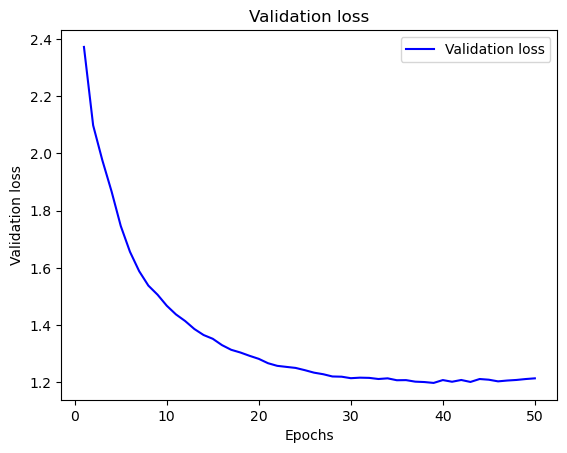

In [34]:
import matplotlib.pyplot as plt

val_loss = history.history['val_loss']

epochs=range(1,51)
plt.plot(epochs,val_loss,'b-',label ='Validation loss')

plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

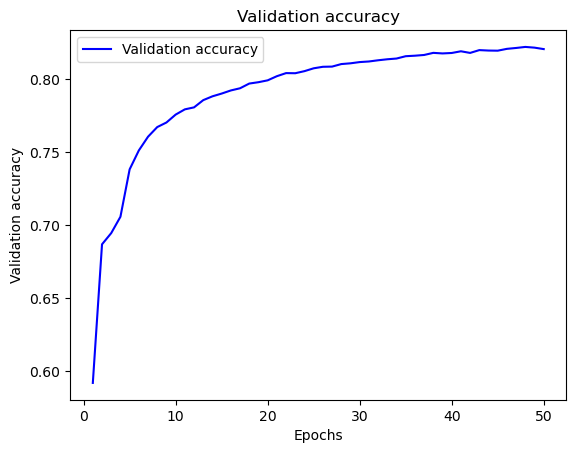

In [35]:
import matplotlib.pyplot as plt

val_loss = history.history['val_accuracy']

epochs=range(1,51)
plt.plot(epochs,val_loss,'b-',label ='Validation accuracy')

plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

## Step 5. 모델 구현하기

In [36]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb_layer(decoder_inputs), initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [37]:
def decode_sequence(input_seq):

  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    
    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])    
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char
    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [38]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [39]:
for seq_index in [2789, 25111, 176, 7895,4567, 27895, 6547,10000]: 
  #print('seq_index',seq_index)
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  #print('input_seq',input_seq)
  decoded_sentence = decode_sequence(input_seq)
  
  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 15ms/step
입력문장 : are you mad ? 
정답문장 : êtes-vous dingues ? 
번역문장 : êtes-vous fou ? 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : he became furious . 
정답문장 : il est devenu furieux . 
번역문장 : il est devenu furieux . 
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : be nice . 
정답문장 : sois gentil ! 
번역문장 : soyez gentille ! 
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
입력문장 : i trusted you . 
정답문장 : je vous faisais confiance . 
번역문장 : je vous faisais confiance . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : are you bald ? 
정답문장 : êtes-vous chauve ? 
번역문장 : êtes-vous chauve ? 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : she's open-minded . 
정

## Step 6. 모델 평가하기

In [42]:
for seq_index in  [4, 57, 230, 345,533, 1257, 1845,2847]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 16ms/step
입력문장 : what a lovely day ! 
정답문장 : quelle journée délicieuse . 
번역문장 : quelle journée pourrie ! 
--------------------------------------------------
1/1 [==============================] - 0s 22ms/step
입력문장 : what have you got ? 
정답문장 : qu'est-ce que vous avez ? 
번역문장 : qu'est-ce qui vous a ? 
--------------------------------------------------
1/1 [==============================] - 0s 21ms/step
입력문장 : which tooth hurts ? 
정답문장 : quelle est la dent qui fait mal ? 
번역문장 : est-ce que ce que je suis le chef ? 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : why give it to me ? 
정답문장 : pourquoi me le donner ? 
번역문장 : pourquoi devrais-je ! 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : you have to focus . 
정답문장 : tu dois te concentrer . 
번역문장 : tu dois nous concentrer . 
------------------------------------------------

- 입력문장 : what a lovely day ! 정말 좋은 날씨야!
- 정답문장 : quelle journée délicieuse . 정말 멋진 날이죠.
- 번역문장 : quelle journée pourrie ! 정말 끔찍한 날이군! X 
- <br>   
- 입력문장 : what have you got ? 너는 무엇을 가지고 있니?
- 정답문장 : qu'est-ce que vous avez ?  뭐가 있죠?
- 번역문장 : qu'est-ce qui vous a ? 왜 그러세요? X
- <br>
- 입력문장 : which tooth hurts ? 어떤 이가 아프니?
- 정답문장 : quelle est la dent qui fait mal ? 어떤 이가 아픈가요?
- 번역문장 : est-ce que ce que je suis le chef ? 내가 치프인가?  X
- <br>
- 입력문장 : why give it to me ? 왜 나한테 줘?
- 정답문장 : pourquoi me le donner ? 왜 제게 그것을 주나요?
- 번역문장 : pourquoi devrais-je ! 내가 왜 그래야 하지? X
- <br>
- 입력문장 : you have to focus . 너는 집중해야 한다
- 정답문장 : tu dois te concentrer . 너는 정신을 바짝 차려야 한다
- 번역문장 : tu dois nous concentrer . 너는 우리 일에 집중해야 한다 O
- <br>
- 입력문장 : clean up this mess . 이 난장판을 치워라
- 정답문장 : nettoie ce bazar . 이 잡동사니들을 치워라
- 번역문장 : nettoyez ce que c'est . 무엇인지를 깨끗이 닦다  O
- <br>
- 입력문장 : have you found tom ? 톰을 찾았나요?
- 정답문장 : avez-vous trouvé tom ? 톰을 찾았나요?
- 번역문장 : as-tu appelé tom ? 톰한테 전화했어? O
- <br>
- 입력문장 : i know it's a mess . 엉망인 거 알아
- 정답문장 : je sais que c’est le bordel . 난장판인 거 알아
- 번역문장 : je connais ce que j'ai un coup . 나는 내가 무슨 일을 당했는지 안다 X


# Step 7. 회고

- RNN을 통해 encoder, decoder를 tensorflow functional API을 이용해서 구현해 보았다. (sequential model, functional API, subclassing 3가지 방식중에서)
- RNN을 처음 학습시에 이전 State값을 기억해서 다음 연산에 쓴다는 것은 알았는데, 실제 구현하면서 내용에 대한 이해가 깊어졌다. 
- NODE 학습에서 문자기반을 학습하다가 단어기반으로 바꾸면서 Tokenizer설정부분이 달라졌고, Embedding Layer를 써서 단어사이에 유사관계를 통해 모델의 표현력을 더 높일 수 있었다. 
- 번역기의 최종 품질이 생각만큼 높지 않아서 정확도를 높여줄 수 있는 방안으로는 데이타 자체를 순차적으로 slice로 분리하지 않고 랜덤하게 split시켜서 시도해 볼만하고, 좀 더 많은 양의 데이타로 train을 시도해 볼 수 있겠다. 
 

# Step 8. 참고자료

https://wikidocs.net/24996